# PROYECTO - 3 FILTROS - INFORME

### David Alejandro Henao - Maria Camila Bravo

#### Objetivo: Implementar un flujo de procesamiento que incluya filtrado de las señales y extracción de características espectrales



## 1. ENTREGABLE

1. Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

**Robust LOESS:**

Este método es una variante robusta del ajuste LOESS, que elimina el "baseline wandering" o deriva de línea base en las señales de ECG. El ajuste LOESS (Locally Estimated Scatterplot Smoothing) es una técnica de suavizado que aplica regresión local para adaptar una curva en segmentos pequeños de datos. La versión robusta es particularmente útil para evitar que datos atípicos influyan en el ajuste, lo que ayuda a mantener la señal ECG en su forma original sin que las desviaciones lentas o las variaciones lentas interfieran en la interpretación de la señal​ [1].

En Python se podría realizar ajustes lineales locales ponderados. se puede usar la biblioteca statsmodels de Python para aplicar LOWESS. El paquete incluye una función lowess y se puede controlar el grado de suavizado ajustando el parámetro frac y aplicar un ajuste robusto para reducir la influencia de valores atípicos en los datos. Un ejemplo básico con statsmodels genera una curva suavizada a partir de datos con ruido, y se puede ver cómo el suavizado ayuda a representar la tendencia principal de los datos de forma clara [2].

**Non-Local Means (NLM):**

El algoritmo NLM se usa para eliminar el ruido residual restante después de aplicar el filtro LOESS. Este método es especialmente útil para preservar las estructuras repetitivas de las señales. NLM promedia puntos de datos cercanos que tienen patrones similares, lo cual ayuda a reducir el ruido sin afectar la estructura de la señal. Para cada punto, el algoritmo evalúa su similitud con otros puntos en un rango predefinido y luego calcula un promedio ponderado que mantiene las características de la señal mientras elimina ruido aleatorio[1].

Para implementar NLM, en Python la biblioteca scikit-image tiene una función denoise_nl_means la cual se puede usar para la reducción de ruido en imágenes y puede adaptarse a series temporales como ECG. El método compara cada punto con otros en un rango definido y calcula un promedio ponderado según la similitud de patrones, lo que ayuda a eliminar ruido sin distorsionar los detalles de la señal[3].


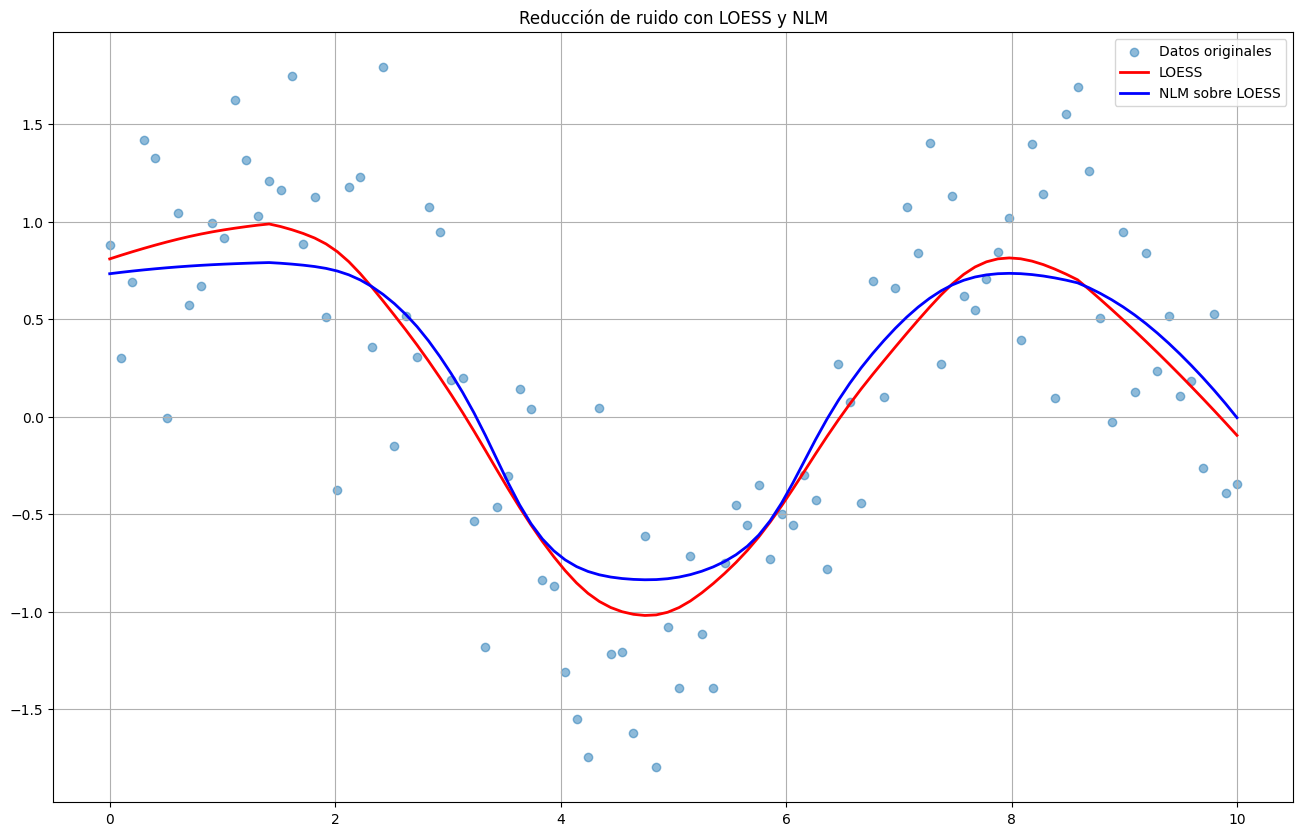

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Aqui generamos datos aleatorios
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)

# Aplicar LOESS
lowess = lowess(y, x, frac=0.3,it = 3)# el valor frac va a determinar que tan suave sera la curva, un valor bajo va a generar sobreajuste, y valores altos vana generar más suavizao.
# el valor de it va a determianr que tan robusto es o no el filtrado, a mayor it mas robusto pues habrán más iteraciones.
y_lowess = lowess[:, 1]

# Función para aplicar Non-Local Means
def non_local_means(data, h):
    n = len(data)
    denoised = np.zeros_like(data)
    
    for i in range(n):
        # Calcular las distancias desde el punto i a todos los demás puntos
        distances = np.abs(data - data[i])
        weights = np.exp(-distances**2 / (h**2))
        denoised[i] = np.sum(weights * data) / np.sum(weights)
    
    return denoised

# Aplicar Non-Local Means a la salida de LOESS
h = 0.5  # Parámetro de suavizado
y_nlm = non_local_means(y_lowess, h)

# Graficar resultados
plt.figure(figsize=(16, 10))
plt.scatter(x, y, label='Datos originales', alpha=0.5)
plt.plot(x, y_lowess, color='red', label='LOESS', linewidth=2)
plt.plot(x, y_nlm, color='blue', label='NLM sobre LOESS', linewidth=2)
plt.legend()
plt.grid(True)
plt.title('Reducción de ruido con LOESS y NLM')
plt.show()

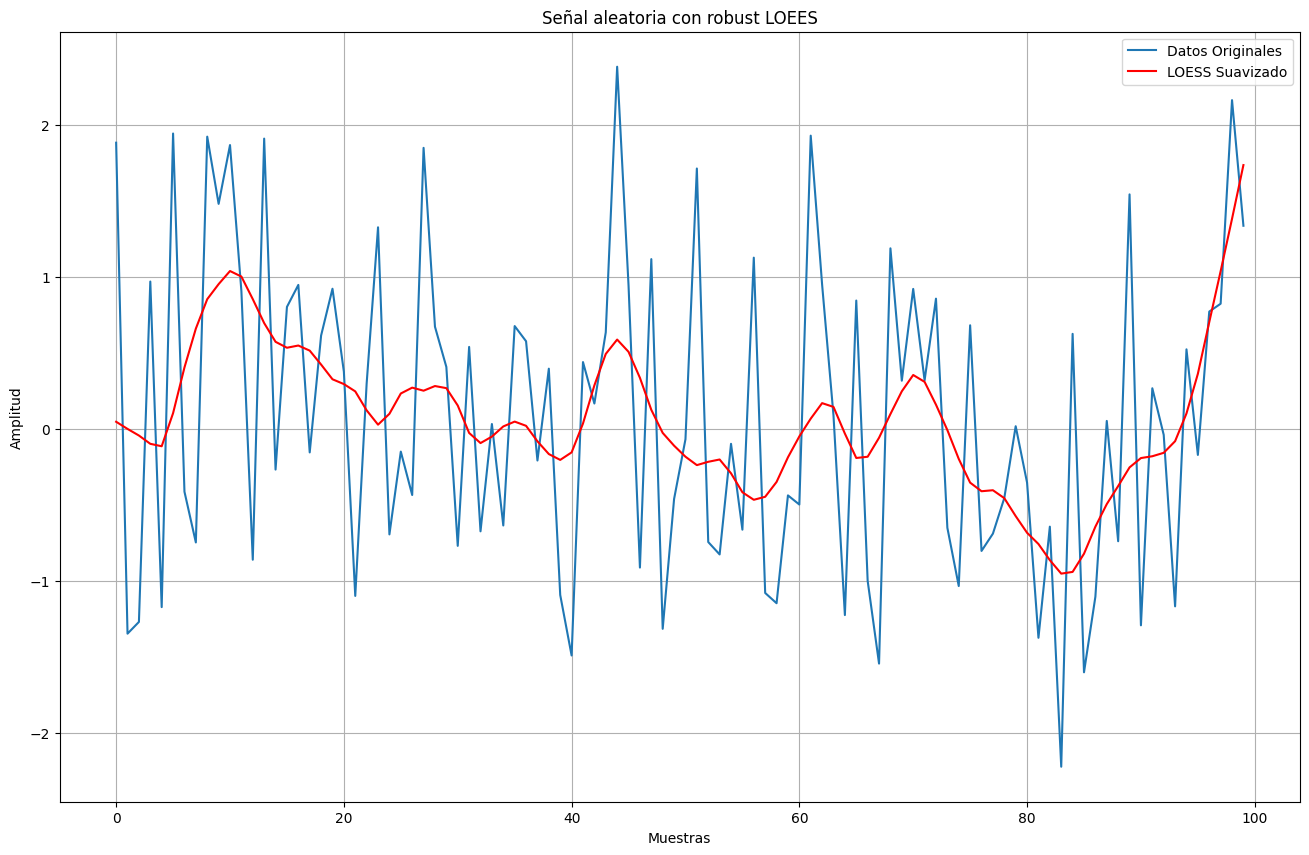

In [27]:
# Con una señal aleatoria continua 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

data = np.random.randn(100)  # Datos de ejemplo
smoothed = lowess(data, np.arange(len(data)), frac=0.1, it=1) 
plt.figure(figsize=(16, 10))
plt.plot(data, label='Datos Originales')
plt.plot(smoothed[:, 0], smoothed[:, 1], label='LOESS Suavizado', color='r')
plt.legend()
plt.xlabel('Muestras')
plt.title('Señal aleatoria con robust LOEES')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

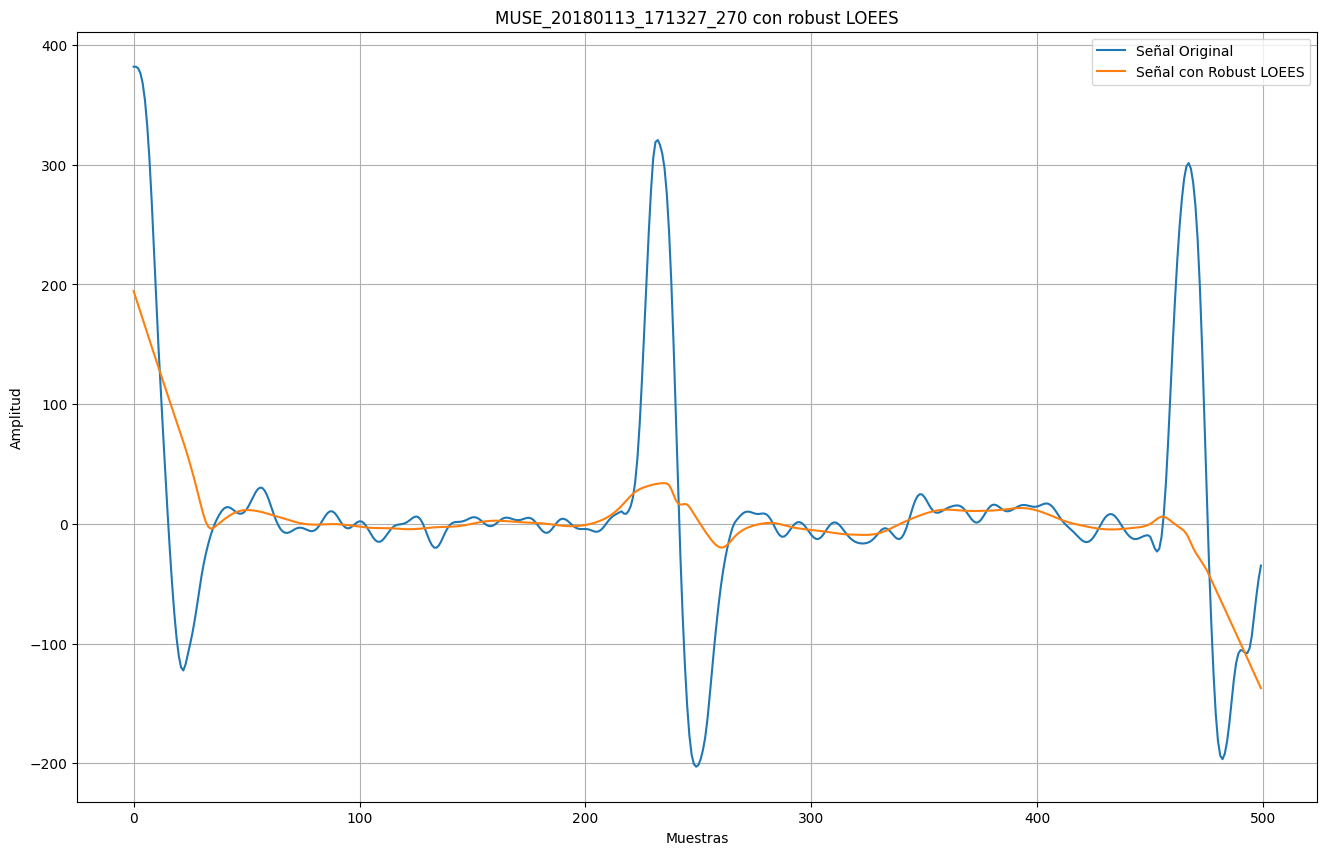

In [28]:
# Ejemplo de uso con una señal de la base de datos:
#csv = r'c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\ECGDataDenoised\MUSE_20180113_171327_27000.csv'
csv = '/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/ECGDataDenoised/MUSE_20180113_171327_27000.csv'
df = pd.read_csv(csv, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
x0 = df['II'].values

smoothed = lowess(x0[:500], np.arange(len(x0[:500])), frac=0.1, it=3) #con 3 iteraciones para que sea 'robusto'

# Visualizar la señal original, la tendencia y la señal des-trendida
plt.figure(figsize=(16, 10))
plt.plot(x0[:500], label='Señal Original')
plt.plot(smoothed[:, 1], label='Señal con Robust LOEES')
plt.legend()
plt.title('MUSE_20180113_171327_270 con robust LOEES')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

## 2.EXTRACIÓN DE REGISTROS 

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [29]:
#ruta = "c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\Diagnostics.xlsx"
ruta = "/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/Diagnostics.xlsx"

dataframe = pd.read_excel(ruta)
df_filtrado= dataframe[(dataframe['Rhythm'] == 'SB') | (dataframe['Rhythm'] == 'AFIB')]
df_filtrado = df_filtrado.reset_index(drop=True)
df_filtrado = df_filtrado[['FileName','Rhythm']]
df_filtrado.head()

,FileName,Rhythm
0,MUSE_20180113_171327_27000,AFIB
1,MUSE_20180112_073319_29000,SB
2,MUSE_20180113_121940_44000,SB
3,MUSE_20180112_120347_79000,SB
4,MUSE_20180114_075026_69000,AFIB


In [30]:
# Función para la extracción de los datos
def obtener_nombres_archivos_por_ritmo(ruta_excel, ritmos_AFIB=['AFIB'], ritmos_SB=['SB']):
    dataframe = pd.read_excel(ruta_excel)
    # Filtrar por los ritmos deseados y extraer los nombres de archivo
    nombres_AFIB = dataframe[dataframe['Rhythm'].isin(ritmos_AFIB)]['FileName'].tolist()
    nombres_SB = dataframe[dataframe['Rhythm'].isin(ritmos_SB)]['FileName'].tolist()
    return nombres_AFIB, nombres_SB

def leer_archivos_ecg(nombres_AFIB, nombres_SB, ruta_carpeta):
    datos_AFIB = {}
    datos_SB = {}
    
    for nombre_archivo in nombres_AFIB + nombres_SB:
        ruta_archivo = os.path.join(ruta_carpeta, f"{nombre_archivo}.csv")
        
        # Verificar si el archivo existe
        if os.path.exists(ruta_archivo):
            df = pd.read_csv(ruta_archivo, delimiter=',', skiprows=1, names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            # Guardar los datos de la columna 'II'
            if nombre_archivo in nombres_AFIB:
                datos_AFIB[nombre_archivo] = df['II'].values
            else:
                datos_SB[nombre_archivo] = df['II'].values
        else:
            print(f"Archivo {ruta_archivo} no encontrado.")
    
    return datos_AFIB, datos_SB

In [31]:
# Ruta al archivo Excel y a la carpeta de archivos .csv
#ruta_excel = r'c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\Diagnostics.xlsx'
#ruta_carpeta_csv =  r'c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\ECGDataDenoised'
ruta_excel = "/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/Diagnostics.xlsx"
ruta_carpeta_csv = "/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/ECGDataDenoised"


# Extraer los nombres de archivos que nos interesan
nombres_AFIB, nombres_SB = obtener_nombres_archivos_por_ritmo(ruta_excel)

# Leer los datos de los archivos ECG
valores_AFIB, valores_SB = leer_archivos_ecg(nombres_AFIB, nombres_SB, ruta_carpeta_csv)

# 3.CONSULTA

#### TIPOS DE SEÑALES WAVELET
Para el análisis de señales ECG las cuales incluyen componentes de frecuencia diferentes y ubicaciones temporales distintas. Es común usar las siguientes familias de wavelet: Daubechies, Symlet, coiflet ,  Meyer y Mexican[4]. 
### Symlet Wavelet
Las wavelets Symlet son wavelets casi simétricas y tienen propiedades similares a la familia db, quienes fueron diseñadas para mejorar la simetría y la regularidad, lo que las hace más adecuadas para representar señales con características específicas en el dominio de la frecuencia y el tiempo[4]. Se recomiendan en aplicaciones donde se requiere alta precisión en la reconstrucción de señales y reducción de distorsión.  Ejemplo en Análisis de señales ECG: Mejoran la precisión al filtrar ruido sin distorsionar los detalles críticos de la señal cardíaca.
### Coiflet (coif) Wavelet :
Estas wavelets tienen soporte compacto lo que se definen en un intervalo finito, que mejora su eficiencia en aplicaciones computacionales[5]. Están diseñadas con un número específico de momentos de desvanecimiento (propiedades que ayudan a eliminar componentes de baja frecuencia). En las Coiflets, la función wavelet tiene 2N momentos nulos y la función de escalamiento tiene 2N - 1 momentos nulos, lo cual permite una representación precisa en el análisis y reconstrucción de señales. Esta wavelet es ideal para la compresión de señales y procesamiento de imágenes.
### Wavelet Meyer:
Es una wavelet ortogonal con una forma suave e infinitamente diferenciable, Meyer calcula los valores en una cuadrícula regular [5]. Lo que la hace adecuada para capturar variaciones sutiles en señales como el ECG. Debido a su soporte no compacto y su transición gradual en el dominio de frecuencia, puede analizar señales de ECG sin introducir efectos bruscos, lo cual es útil para distinguir componentes de baja frecuencia, como los latidos cardíacos y sus patrones. 
### Mexican  Wavelet:
La wavelet Mexican Hat se obtiene de la segunda derivada de la función Gaussiana y es útil para analizar señales como el ECG debido a su estructura en forma de onda. Al aplicarse un factor de escala y un factor de traslación, la wavelet puede adaptarse a diferentes frecuencias y posiciones temporales, lo que la hace eficaz para detectar detalles tanto en el tiempo como en la frecuencia de la señal[6].


CONCLUSIÓN
 En el código entregado en el curso se utiliza la wavelet db6 (Daubechies 6), la cual es muy común en el análisis de las señales ECG. Esta wavelet tiene 6 coeficientes y tiene la capacidad de filtrar ruidos mientras mantiene detalles importantes de la señal. En el caso de señales ECG, Para la bradicardia sinusal (SB) y la fibrilación auricular (AFIB), el uso de Daubechies (db6) mantiene las  características principales, detecta las señales rápidas, reduce el ruido y descompone la señal. Como en el complejo QRS, sin distorsionar las ondas P y T. 
 En el caso de Fibrilación las señales tienen patrones irregulares debido a las arritmias, mientras que en la bradicardia presentan señales de frecuencia más lentas por lo tanto con base en la consulta se podria probar con wavelet sym o coif la cual podría realizar detección de patrones más complejos y detención de las variaciones en las ondas P y T, sin perder detalles importantes en señales con baja frecuencia y alta variabilidad.

In [37]:
# Código entregado en el curso 
def filtro_denoise_wavelet(entrada, wavelet='db6', nivel=8):
    # Paso 1: Descomposición en coeficientes wavelet
    coeficientes = pywt.wavedec(entrada, wavelet, level=nivel)
    detalles = coeficientes[1:]  # Ignorar la aproximación inicial en el nivel más alto

    # Paso 2: Cálculo de la desviación estándar del ruido (basado en wnoisest)
    desviaciones_std = [np.median(np.abs(detalle)) / 0.6745 for detalle in detalles]

    # Paso 3: Cálculo del umbral (basado en threshold)
    num_muestras = sum([detalle.size for detalle in detalles])
    umbral = np.sqrt(2 * np.log(num_muestras))

    # Paso 4: Aplicar el umbral a los coeficientes detallados (basado en wthresh)
    detalles_filtrados = []
    for i, detalle in enumerate(detalles):
        umbralizado = np.multiply(detalle, np.abs(detalle) > (umbral * desviaciones_std[i]))
        detalles_filtrados.append(umbralizado)

    # Reconstruir la señal utilizando los coeficientes de aproximación original y los detalles filtrados
    coeficientes_filtrados = [coeficientes[0]] + detalles_filtrados
    señal_filtrada = pywt.waverec(coeficientes_filtrados, wavelet)
    señal_filtrada = señal_filtrada[:entrada.shape[0]]  # Asegurar que la longitud coincide

    # Graficar señal original
    plt.figure(figsize=(12, 6))
    plt.plot(entrada, label='Señal Original')
    plt.title("Señal Original")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

    # Graficar señal filtrada (reconstruida)
    plt.figure(figsize=(12, 6))
    plt.plot(señal_filtrada, label='Señal Filtrada (Reconstruida)', color='orange')
    plt.title("Señal Filtrada")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

    return señal_filtrada, umbral, desviaciones_std

In [36]:
valores_SB

{'MUSE_20180112_073319_29000': array([21.567, 16.269, 11.313, ..., 12.501, 11.9  , 11.158]),
 'MUSE_20180113_121940_44000': array([117.41 , 115.43 , 112.03 , ...,  11.557,  10.687,  10.046]),
 'MUSE_20180112_120347_79000': array([ 7.0583,  8.533 , 10.062 , ..., 19.01  , 30.395 , 42.41  ]),
 'MUSE_20180114_075128_92000': array([ 9.4703 , 15.396  , 19.489  , ..., -4.3145 , -0.84292,  2.7626 ]),
 'MUSE_20180118_174026_42000': array([-57.138, -49.756, -43.773, ..., -42.091, -35.226, -25.615]),
 'MUSE_20180115_125443_25000': array([ -0.77577,   0.74095,   2.3101 , ..., 117.13   , 122.05   ,
        126.66   ]),
 'MUSE_20180113_134825_04000': array([-12.598, -14.603, -15.258, ...,  54.586,  50.783,  47.336]),
 'MUSE_20180114_070718_20000': array([ 15.858 ,  10.079 ,   6.5347, ..., -23.374 , -21.563 , -18.837 ]),
 'MUSE_20180115_133559_70000': array([-65.338, -63.796, -62.787, ..., -14.698, -14.458, -13.775]),
 'MUSE_20180113_071734_35000': array([-39.718, -43.247, -46.2  , ...,  40.648,  47.

#### EJEMPLO Symlet (sym)

Se requiere instalar  PyWavelets ,

In [34]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Función para aplicar el filtro de reducción de ruido usando wavelet
def filtro_denoise_wavelet(signal, wavelet='sym5', nivel=5):
    # Descomposición de la señal en coeficientes wavelet
    coeficientes = pywt.wavedec(signal, wavelet, level=nivel)
    detalles = coeficientes[1:]  # Ignoramos la aproximación en el nivel más alto

    # Calcular desviación estándar del ruido y umbral
    desviaciones_std = calcular_ruido(detalles)
    umbral = calcular_umbral(detalles)

    # Umbralizar los detalles para reducir el ruido
    detalles_filtrados = []
    for i, detalle in enumerate(detalles):
        detalle_umbralizado = np.multiply(detalle, np.abs(detalle) > (umbral * desviaciones_std[i]))
        detalles_filtrados.append(detalle_umbralizado)

    # Reconstrucción de la señal filtrada
    coeficientes_filtrados = [coeficientes[0]] + detalles_filtrados
    señal_filtrada = pywt.waverec(coeficientes_filtrados, wavelet)
    señal_filtrada = señal_filtrada[:len(signal)]  # Ajuste de longitud a la señal original

    # Graficar señal original y filtrada
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='Señal Original')
    plt.title("Señal Original")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(señal_filtrada, label='Señal Filtrada (Reconstruida)', color='orange')
    plt.title("Señal Filtrada")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

    return señal_filtrada, umbral, desviaciones_std

# Función para calcular la desviación estándar del ruido (basado en la mediana)
def calcular_ruido(coeff):
    return [np.median(np.abs(detalle)) / 0.6745 for detalle in coeff]

# Función para calcular el umbral universal
def calcular_umbral(coeff):
    num_muestras = sum([detalle.size for detalle in coeff])
    return np.sqrt(2 * np.log(num_muestras))


## 4. FLUJO DE PROCESAMIENTOS

Escoger 10 señales al azar y aplicar un flujo de procesamiento que conste de:

In [35]:
import random # para seleccionar de forma aleatoria las 10 señales

def seleccionar_señales_aleatorias(valores_SB, valores_AFIB, num_selecciones=5):
    # Asegurarse de que hay suficientes señales para seleccionar
    if len(valores_SB) < num_selecciones or len(valores_AFIB) < num_selecciones:
        raise ValueError("No hay suficientes señales en uno de los diccionarios para seleccionar.")

    # Seleccionar claves aleatorias
    claves_SB = random.sample(list(valores_SB.keys()), num_selecciones)
    claves_AFIB = random.sample(list(valores_AFIB.keys()), num_selecciones)

    # Obtener las señales correspondientes
    señales_SB = {clave: valores_SB[clave] for clave in claves_SB}
    señales_AFIB = {clave: valores_AFIB[clave] for clave in claves_AFIB}

    return señales_SB, señales_AFIB

# Llamar a la función
señales_SB_aleatorias, señales_AFIB_aleatorias = seleccionar_señales_aleatorias(valores_SB, valores_AFIB)

# Imprimir las señales seleccionadas
print("Señales SB seleccionadas:", señales_SB_aleatorias)
print("Señales AFIB seleccionadas:", señales_AFIB_aleatorias)

Señales SB seleccionadas: {'MUSE_20180114_172013_66000': array([ 71.293,  60.748,  50.359, ..., -23.171, -21.7  , -20.466]), 'MUSE_20180118_171644_79000': array([56.822 , 60.893 , 61.829 , ..., -8.3318, -6.63  , -4.2651]), 'MUSE_20180113_183930_93000': array([-24.546 , -12.835 ,  -5.2135, ...,   1.4031,  -8.3109, -20.128 ]), 'MUSE_20180118_175257_00000': array([63.256  , 64.681  , 66.873  , ...,  0.93525,  6.6924 , 13.611  ]), 'MUSE_20180113_124534_64000': array([-2.8602, -2.8258, -2.791 , ..., 63.571 , 62.984 , 62.27  ])}
Señales AFIB seleccionadas: {'MUSE_20180118_132321_41000': array([45.39   , 49.483  , 58.161  , ...,  4.4555 ,  2.9039 ,  0.64436]), 'MUSE_20180118_131837_83000': array([ 26.282,  30.469,  36.959, ..., 273.45 , 300.13 , 325.97 ]), 'MUSE_20180114_070243_70000': array([49.443 , 48.963 , 47.468 , ...,  6.7315, 10.077 , 14.394 ]), 'MUSE_20180112_124901_96000': array([-1.1322, -4.3208, -6.9713, ..., 11.905 , 18.532 , 25.911 ]), 'MUSE_20180111_170243_72000': array([31.122,

### FUJO 1 

### FUJO 2

### FUJO 3

Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)

Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.

A las señales filtradas con el flujo seleccionado aplicar el procesamiento de normalización usado en el proyecto 2.

## 5. Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

## 6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

## 7.Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2. 